In [1]:
import numpy as np
import random
import torch
import os
import sys
from torch.utils.data import (DataLoader,      # library for data loading.
                              Dataset)         # library for dataset.

sys.path.append(os.path.abspath(".."))
from src.pipelines.data_pipeline import DataPipeline
from collections import Counter
from src.pipelines.dataset import collate_fn_hierarchical
from src.train.train import compute_class_weights, MultiTaskTrainer
from src.models.hierarchical_model import HierarchicalMultiTaskModel
from src.inference.predict import predict_rest_mex_test

np.random.seed(0)                              # seed for reproducibility.
random.seed(0)                                 # seed for reproducibility.
torch.manual_seed(0)                           # seed for reproducibility.
torch.backends.cudnn.benchmark = False         # reproducibility.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
pipeline = DataPipeline(device = device)

max_len = 243 (percentil 99)


In [7]:
train_dataloader = DataLoader(
    pipeline.train_dataset,
    batch_size = 8,  # <- 8 pueblos por batch
    shuffle    = True,
    collate_fn = collate_fn_hierarchical
)
val_dataloader = DataLoader(
    pipeline.val_dataset,
    batch_size = 8,
    shuffle    = False,
    collate_fn = collate_fn_hierarchical
)

batch = next(iter(train_dataloader))
print("Train batch shape :", batch[0].shape)
print("Labels shape      :", batch[1].shape)

Train batch shape : torch.Size([8, 1, 243])
Labels shape      : torch.Size([8, 1])


In [8]:
counter_polarity = Counter([int(p[0]) for p in pipeline.labels])
counter_town = Counter([p[1] for p in pipeline.labels])
counter_type = Counter([p[2] for p in pipeline.labels])

print("Polarity Counter:", counter_polarity)
print("Town Counter:", counter_town)
print("Type Counter:", counter_type)

Polarity Counter: Counter({5: 136561, 4: 45034, 3: 15519, 2: 5496, 1: 5441})
Town Counter: Counter({'Tulum': 45345, 'Isla_Mujeres': 29826, 'San_Cristobal_de_las_Casas': 13060, 'Valladolid': 11637, 'Bacalar': 10822, 'Palenque': 9512, 'Sayulita': 7337, 'Valle_de_Bravo': 5959, 'Teotihuacan': 5810, 'Loreto': 5525, 'TodosSantos': 4600, 'Patzcuaro': 4454, 'Taxco': 4201, 'Tlaquepaque': 4041, 'Ajijic': 3752, 'Tequisquiapan': 3627, 'Metepec': 3532, 'Tepoztlan': 3445, 'Cholula': 2790, 'Tequila': 2650, 'Orizaba': 2521, 'Izamal': 2041, 'Creel': 1786, 'Ixtapan_de_la_Sal': 1696, 'Zacatlan': 1602, 'Huasca_de_Ocampo': 1509, 'Mazunte': 1466, 'Xilitla': 1458, 'Atlixco': 1444, 'Malinalco': 1429, 'Bernal': 1252, 'Tepotzotlan': 1013, 'Cuetzalan': 996, 'Chiapa_de_Corzo': 960, 'Parras': 953, 'Dolores_Hidalgo': 909, 'Coatepec': 818, 'Cuatro_Cienegas': 788, 'Real_de_Catorce': 760, 'Tapalpa': 725})
Type Counter: Counter({'Restaurant': 86720, 'Attractive': 69921, 'Hotel': 51410})


In [9]:
embedding_matrix = pipeline.emb_mat.clone().detach().to(dtype = torch.float, device = device)
modelHierarchical = HierarchicalMultiTaskModel(
    vocab_size       = pipeline.emb_mat.shape[0],
    embed_dim        = embedding_matrix.shape[1],
    hidden_size      = 2,
    num_polarities   = 5,
    num_types        = 3,
    num_towns        = 40,
    embedding_matrix = embedding_matrix
).to(device)

trainerHierarchical = MultiTaskTrainer(
    model            = modelHierarchical,
    epochs           = 1,
    train_dataset    = pipeline.train_dataset,
    train_dataloader = train_dataloader,
    val_dataloader   = val_dataloader,
    device           = device,
    lr               = 1e-3,
    patience         = 1,
    weight_decay     = 1e-4,
    type2id          = pipeline.type2id,
    town2id          = pipeline.town2id,
    lambdas          = (5/48, 40/48, 3/48),
    polarity_counter = counter_polarity,
    town_counter     = counter_town,
    type_counter     = counter_type,
    checkpoint_filename = 'checkpoint_hierarchical.pth',
    best_model_filename = 'best_model_hierarchical.pth',
)

Evaluation... : 100%|██████████| 5202/5202 [01:19<00:00, 65.66it/s]


 Epoch  1/1  ➤ Training loss: 2.825716 | Val Loss: 2.9265 | Res_P = 0.2016 | Res_T = 0.5679 | Res_Town = 0.1420 | Final Score = 0.2329 | Epoch Time: 2696.75 s | Total Time: 2692.95 s

--- Total Training Time: 2692.95 seconds ---
Best model achieved at epoch 1 with Final Score = 0.2329


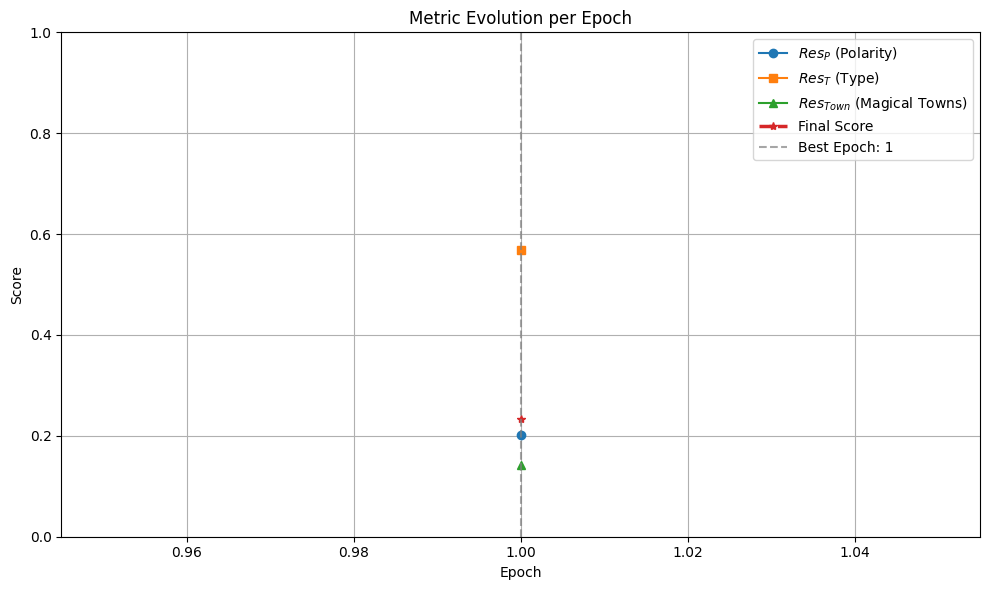

In [14]:
trainerHierarchical.train()

trainerHierarchical.plot_metrics()

In [10]:
trainerHierarchical.load_model('best_model_hierarchical.pth')  # carga el mejor

Modelo cargado desde best_model_hierarchical.pth


In [11]:
predict_rest_mex_test(
    model           = modelHierarchical,
    pipeline        = pipeline,
    output_filename = 'final.txt',
    device          = device,
)

Predicting Test Set: 100%|██████████| 1394/1394 [00:18<00:00, 77.16it/s]


Archivo generado: final.txt
